In [55]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [56]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

In [57]:
!chmod 600 ~/.kaggle/kaggle.json

In [58]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [59]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [60]:
train_path = '../content/train.zip'
test_path = '../content/test1.zip'

files = 'kaggle/working'
with zipfile.ZipFile(train_path, 'r') as z:
    z.extractall(files)

with zipfile.ZipFile(test_path, 'r') as z:
    z.extractall(files)

In [61]:
image_dir = "../content/kaggle/working/train/"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})
data.head()

,filename,label
0,cat.7176.jpg,cat
1,cat.9237.jpg,cat
2,cat.5083.jpg,cat
3,dog.8756.jpg,dog
4,dog.11501.jpg,dog


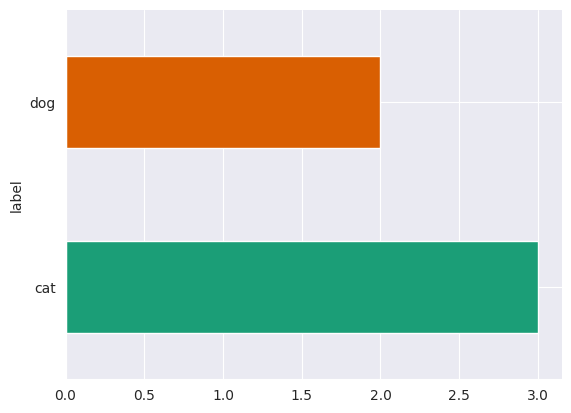

In [62]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Train test split

In [63]:
labels = data['label']
X_train,X_temp = train_test_split(data,test_size=0.2,random_state=42,stratify=labels)

label_test_val = X_temp['label']
X_test,X_val = train_test_split(X_temp,test_size=0.5,stratify=label_test_val,random_state = 42)

In [64]:
print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)


The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


In [65]:
# parameters
image_size = 128
image_channel = 3
batch_size = 32

In [66]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   shear_range=0.1,
                                   fill_mode='reflect',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

In [67]:
train_generator = train_datagen.flow_from_dataframe(dataframe=X_train,
                                                    directory='../content/kaggle/working/train/',
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(image_size,image_size),
                                                    class_mode='binary',
                                                    batch_size=batch_size,
                                                    shuffle=False)

validation_generator = test_datagen.flow_from_dataframe(dataframe=X_val,
                                                        directory='../content/kaggle/working/train/',
                                                        x_col='filename',
                                                        y_col='label',
                                                        target_size=(image_size,image_size),
                                                        class_mode='binary',
                                                        batch_size=batch_size,
                                                        shuffle=False)

test_generator = test_datagen.flow_from_dataframe(dataframe=X_test,
                                                  directory='../content/kaggle/working/train/',
                                                  x_col='filename',
                                                  y_col='label',
                                                  target_size=(image_size,image_size),
                                                  class_mode='binary',
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [68]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(image_size,image_size,image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1,activation='sigmoid'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,112,001 (19.50 MB)

 Trainable params: 5,110,017 (19.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

# Callbacks
- ReduceLROnPlateau
- EarlyStopping

In [69]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [70]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [71]:
cat_dog = model.fit(train_generator,
                    validation_data = validation_generator,
                    callbacks=[early_stopping,learning_rate_reduction],
                    epochs=30,
                    )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 196ms/step - accuracy: 0.6119 - loss: 0.8027 - val_accuracy: 0.7244 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.7297 - loss: 0.5411 - val_accuracy: 0.7268 - val_loss: 0.5163 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - accuracy: 0.7724 - loss: 0.4726 - val_accuracy: 0.8116 - val_loss: 0.4178 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 194ms/step - accuracy: 0.8091 - loss: 0.4115 - val_accuracy: 0.6976 - val_loss: 0.7334 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8332 - loss: 0.3714
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 193ms/step - accuracy: 0.8332 - loss: 0.3714 - val_accuracy: 0.7808 - val_loss: 0.5306 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 196ms/step - accuracy: